# 
# Senior Machine Learning Engineer - Technical Test


## <font color='red'>[IMPORTANT: Read this first!!]</font>

The goal of this assignment is quite simple: you have been given a sequence of GNSS fixes that were taken during a car trip. These trips have missing parts (fixes) and you have to fill these gaps. The problem is further described below, and there are also specific TODOs all over this notebook where your input is required.

In the data folder you will find several data sources:

#### gnss.pos

This data was obtained by applying RTK to GNSS fixes using RTKLIB. The details are not relevant for this exercise, but RTKLIB uses uses base stations to correct and improve the original GNSS fixes. In difficult scenarios (narrow road, high buildings, i.e. "urban canyons") the algorithm fails to come up with a decent solution and drops the fix. All you need to know is that this results in gaps where there is no GNSS solution. The data is sampled at 20Hz (every 0.05 seconds) and the time difference between is exactly 0.05 seconds, starting at each exact second. When the gap is larger, that means there are fixes missing and you need to interpolate the data. 

Code has been provided for you to read in the data to a Pandas DataFrame in the "Data prep" section. You can read about the columns in gnss.py module, but the basic columns you might need are "lat", "lng" and "height" for latitude,  longitude and height/altitude.

#### yocto.*.csv
Several csv files sampled from a YOCTO-3D-V2 device. The data has been resampled to 20Hz for you, although you might want to know that the original data was a bit lower in frequency (more like ~7Hz depending on the data source). You can safely ignore frequency issues. If you want to, you can use the low_pass_df or high_pass_df methods in signals.py module.

You have three sensors: Accelerometer (accelerations in G-forces applied to each axis X, Y, Z), Gyroscope (rotations in degrees/s around each axis X, Y, Z) and Compass (bearing in degrees around X/Y plane, with 0° being geographic North). You can assume that Z axis is pointing upwards, X axis is aligned with reverse direction of the car and the Y axis is pointing to the right of the car.

Similarly as with the GNSS data, code is provided to read in the data. The timestamps in these files have already been aligned with the timestamps in gnss.pos. For every GNSS sample (including the missing ones), there is one sample for each of the sensor values.

This means that
- Accelerometer X contains the (inverted) accelerations of the car itself. Multiply it by 9.81 to get actual accelerations in m/s^2. Then a positive peak will correspond to the driver pushing the acceleration pedal and negative peak will correspond to that driver braking the car.
- The Accelerometer also measures gravity, but you can assume that it's mostly in the Z-axis, although I would advise to subtract the average from the other two axes if you use them.
- The Gyroscope Z-axis corresponds with the car turning. Positive value means counter clockwise rotation.

### Assignment
1. Implement a solution that interpolates the latitude and longitude columns of the GNSS data for the missing parts. 
2. You're required to at least use one of the following data sources:
    - GNSS velocity
    - Accelerations from the accelerometer
    - Gyroscope car rotations
    - Compass
3. Visualize the comparison between original and interpolated data.
4. Write at least one test method using the assert function that tests a core part of your implementation

### Notes
- You're allowed to change the other GNSS fixes as well if that makes it easier and if that improves them, but it is not required.
- The implementation and idea is more important than the actual outcome
- If you do run out of time, make sure to finish step 3. and 4. and describe how you would finish step 2.
- Simple linear interpolation of latitude and longitude is not allowed :)
- You're free to use any open source code as long as it can be executed from this notebook (including python wrapped C/C++ code) and you can explain roughly how it works

### Dependencies

- arrow==0.12.1
- matplotlib==3.1.1
- numpy==1.17.0
- pandas==1.0.0
- scipy==1.4.1


<font color='red'>**TODO: Add any new python dependencies above**</font>

### Imports

In [1]:
import os
from gnss import read_rtk_solution
from yocto import read_sensors
import numpy as np
import pandas as pd
import math

from signals import interpolate_stamps, resample, sync_df, plot_sensor, SECONDS_2_TIMESTAMP
from matplotlib import pyplot as plt

### Global Variables

In [2]:
DATA_DIR = './data/'
GNSS_FILE_NAME = 'gnss.pos'

### Data prep <font color='red'>[IMPORTANT: don't change anything here]</font>

In [3]:
gnss_df = read_rtk_solution(os.path.join(DATA_DIR, GNSS_FILE_NAME))

gnss_sampling_rate = np.round(1.0 / (np.median(np.diff(gnss_df.timestamp)) / 1e9), 1)

gnss_df

,date,time,lat,lng,height,Q,ns,sdn,sde,sdu,...,vn,ve,vu,sdvn,sdve,sdvu,sdvne,sdveu,sdvun,timestamp
0,2020/05/05,12:46:19.800,51.215574,4.392660,51.0563,1,22,0.0028,0.0026,0.0063,...,0.00479,-0.00042,0.00402,0.04019,0.03881,0.03821,0.00431,0.00809,-0.00671,1588682779800000000
1,2020/05/05,12:46:19.850,51.215574,4.392660,51.0562,1,22,0.0028,0.0026,0.0063,...,0.00548,-0.00859,0.00597,0.04021,0.03883,0.03822,0.00432,0.00810,-0.00671,1588682779849999872
2,2020/05/05,12:46:19.900,51.215574,4.392660,51.0558,1,22,0.0028,0.0026,0.0063,...,0.00699,-0.00539,0.00915,0.04026,0.03888,0.03823,0.00433,0.00811,-0.00671,1588682779900000000
3,2020/05/05,12:46:19.950,51.215574,4.392660,51.0563,1,22,0.0028,0.0026,0.0063,...,-0.01337,0.00537,0.00776,0.04029,0.03891,0.03822,0.00429,0.00807,-0.00674,1588682779950000128
4,2020/05/05,12:46:20.000,51.215574,4.392660,51.0570,1,22,0.0027,0.0026,0.0063,...,-0.01783,0.00480,0.00540,0.04007,0.03867,0.03817,0.00415,0.00794,-0.00683,1588682780000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14040,2020/05/05,12:59:58.800,51.215285,4.392227,50.4034,2,21,0.0035,0.0031,0.0137,...,0.00330,0.00579,-0.00568,0.02996,0.02850,0.03026,0.00217,0.00786,0.00330,1588683598800000000
14041,2020/05/05,12:59:58.850,51.215285,4.392227,50.4072,2,20,0.0035,0.0031,0.0137,...,0.00205,0.00562,-0.00224,0.03006,0.02879,0.03050,-0.00110,0.00662,0.00425,1588683598849999872
14042,2020/05/05,12:59:58.900,51.215285,4.392227,50.4078,2,21,0.0035,0.0031,0.0137,...,0.00072,-0.00407,0.00427,0.03006,0.02852,0.03025,0.00240,0.00771,0.00331,1588683598900000000
14043,2020/05/05,12:59:58.950,51.215285,4.392227,50.4050,2,21,0.0035,0.0031,0.0137,...,-0.00499,-0.01217,0.00276,0.03004,0.02856,0.03019,0.00229,0.00785,0.00303,1588683598950000128


In [4]:
sensors = read_sensors(DATA_DIR)
step_size = SECONDS_2_TIMESTAMP / gnss_sampling_rate
target_ts = np.arange(gnss_df.iloc[0].timestamp, gnss_df.iloc[-1].timestamp, step_size, dtype=np.int64)

df_columns = []
df_values = []
for name, sensor_df in sensors.items():
    ts = sensor_df.timestamp.values
    values = sensor_df.value.values.reshape((-1, 1))
    
    # Synchronize the sensors to the timestamps of the GNSS data
    new_ts, new_values = resample(ts, values, gnss_sampling_rate)
    synced_values = interpolate_stamps(new_ts, new_values, target_ts)
    
    df_columns.append(name)
    df_values.append(synced_values)
    
    
    
    
# stack the sensors together now they have the same timestamps
sensors_df = pd.DataFrame(np.hstack(df_values), columns=df_columns)

# Add the timestamps after the hstack, so it keeps the np.int64 dtype
sensors_df['timestamp'] = target_ts
    
    
    
sensors_df    

,accelerometer.x,accelerometer.y,accelerometer.z,gyro.x,gyro.y,gyro.z,compass,timestamp
0,0.096545,-0.029921,0.755578,-0.000188,0.075410,-0.000025,194.624467,1588682779800000000
1,0.106259,-0.036153,1.064624,0.000192,0.101858,0.000024,207.456380,1588682779849999872
2,0.104566,-0.034430,0.965722,-0.000196,0.098110,-0.000026,198.322193,1588682779899999744
3,0.105205,-0.035359,1.022233,0.000200,0.101291,0.000029,205.381945,1588682779949999616
4,0.104881,-0.034747,0.984300,-0.000205,0.099103,-0.000032,199.674720,1588682779999999488
...,...,...,...,...,...,...,...,...
16379,-0.120528,-0.017122,-0.995979,-0.000359,-0.001724,0.096818,112.614585,1588683598747903488
16380,-0.119730,-0.017476,-0.996021,0.000357,-0.000274,0.069848,112.635416,1588683598797903360
16381,-0.118604,-0.017831,-0.995979,-0.000356,0.000231,0.033570,112.614582,1588683598847903232
16382,-0.118045,-0.018000,-0.996022,0.000355,-0.000163,0.005591,112.635420,1588683598897903104


### Visualizing the data

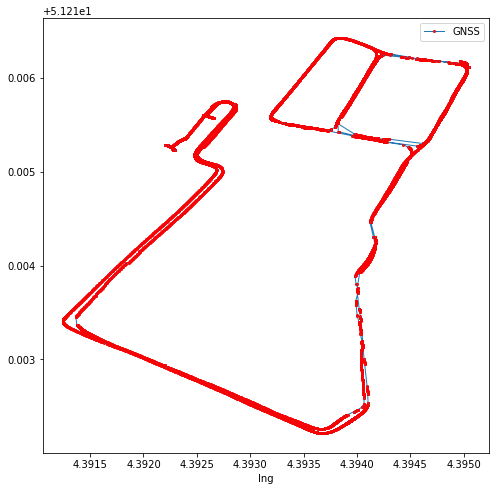

In [5]:
# %matplotlib notebook
# Missing parts are visualized in linearly interpolated blue lines

f, ax = plt.subplots(figsize=(8,8))

gnss_df.plot(x='lng', y='lat', label='GNSS', ax=ax, marker='o', markersize=2, linewidth=1, markeredgecolor='red')
plt.legend()

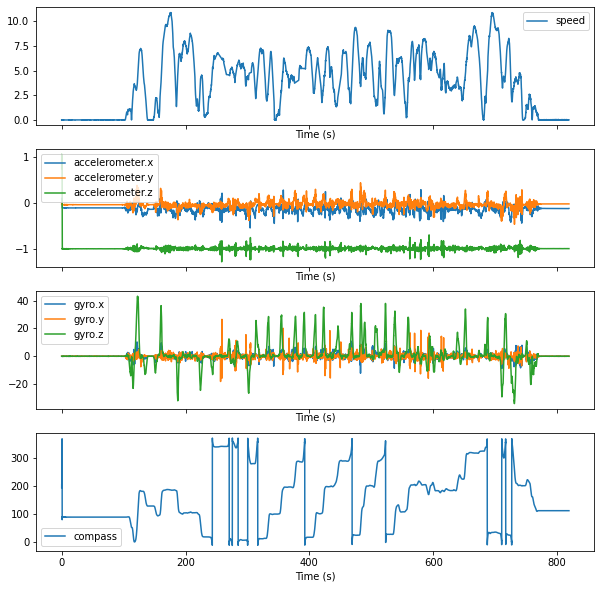

In [6]:
# %matplotlib notebook

f, ax = plt.subplots(4, figsize=(10, 10), sharex=True)

gnss_df['speed'] = np.sqrt(gnss_df.ve *gnss_df.ve + gnss_df.vn * gnss_df.vn + gnss_df.vu *gnss_df.vu )

plot_sensor(gnss_df, ax=ax[0], cols=['speed'])

plot_sensor(sensors_df, ax=ax[1], cols=['accelerometer.x', 'accelerometer.y', 'accelerometer.z'])

plot_sensor(sensors_df, ax=ax[2], cols=['gyro.x', 'gyro.y', 'gyro.z'])

plot_sensor(sensors_df, ax=ax[3], cols=['compass'])


### Implementation 
This code is based on the paper "EPE and Speed Adaptive Extended Kalman Filter for Vehicle Position
and Attitude Estimation with Low Cost GNSS and IMU Sensors" by P. Balzer , T. Trautmann and O. Michler  

In [7]:
# merging sensor and gnss dataframe based on timestamp
gnss_df['timestamp'] = gnss_df['timestamp'].astype('datetime64[ns]')
sensors_df['timestamp'] = sensors_df['timestamp'].astype('datetime64[ns]')

# converting gyros from degree/sec to rad/sec
sensors_df['gyro.x'] = sensors_df['gyro.x'] * np.pi / 180.0
sensors_df['gyro.y'] = sensors_df['gyro.y'] * np.pi / 180.0
sensors_df['gyro.z'] = sensors_df['gyro.z'] * np.pi / 180.0

# converting compass from degree to radians
sensors_df['compass'] = sensors_df['compass'] * np.pi / 180.0

sensors_df['accelerometer.y'] = sensors_df['accelerometer.y'] * 9.81 

# as per equation [12-14] from paper converting lat - long to meters  
gnss_df['z_y'] = (np.pi*(6378388.0 + gnss_df.height)/180.0) * np.cos(gnss_df.lat*np.pi/180.0) * gnss_df.lng
gnss_df['z_x'] = (np.pi*(6378388.0 + gnss_df.height)/180.0) * gnss_df.lat

#merge with sensors and gnss data as a single entity
m = pd.merge_asof(sensors_df, gnss_df, on='timestamp', tolerance=pd.Timedelta('0.049999879442s'), allow_exact_matches=True)

# Columns in data frame to store the values of updated state and NEES error plot
m['ekf_x'] = 0.0
m['ekf_y'] = 0.0
m['ekf_speed'] = 0.0
m['ekf_compass'] = 0.0
m['pitch'] = 0.0
m['roll'] = 0.0
m['NEES'] = 0.0


In [8]:
dt = 0.05 # time stamp in seconds

### Plant Noise Covariance Q
As per paper with equation 17 and given values

In [9]:
jerkmax = 300.0    # m/s3

pitchrateaccmax=  200.0 *np.pi/180.0 # rad/s2
rollrateaccmax =  200.0 *np.pi/180.0 # rad/s2
yawrateaccmax  =  80.0  *np.pi/180.0 # rad/s2


Q = np.diagflat([[(dt * jerkmax)**2],            # acceleration
            [(dt * yawrateaccmax)**2],           # yawrate
            [(dt * pitchrateaccmax)**2],         # pitchrate
            [(dt * rollrateaccmax)**2]])         # rollrate


### Measurement Noise Covariance R
As suggested in the paper I did not consider the Adaptive R as needs some assumptions and if this condition is satisied and time permits I will work on it

In [10]:
R = np.diagflat([[(12.0)**2],      # x
            [(12.0)**2],           # y
            [(1.0)**2],  # v
            [(1.0)**2],  # heading 
            [(0.5)**2],  # pitch
            [(0.5)**2]]) # roll

### Initialization of State and Covariance for EKF based tracker 

The state is initialized with X = (position_X, position_Y, Velocity, heading(yaw), pitch , roll).T as suggested in paper with equation 16

In [11]:
x = np.array([[m.at[0, 'z_x'], m.at[0, 'z_y'], m.at[0, 'speed'], 0, 0, 0]]).T
x

array([[5.70156160e+06],
       [3.06313104e+05],
       [6.26744765e-03],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00]])

### Covariance Intialization 


In [12]:
P = 1e5*np.eye(6)
P

# store state values of x,y co-ordinates into dataframes for ploting future
m.at[0, 'ekf_x'] = x[0]
m.at[0, 'ekf_y'] = x[1]
m.at[0, 'ekf_speed'] = x[2]
m.at[0, 'ekf_compass'] = x[3]
m.at[0, 'pitch'] = x[4]
m.at[0, 'roll'] = x[5]


### Implementation

Kalman Filter as per the above paper mentioned paper implementation

In [13]:
# x - roll
# y - pitch
# z - yaw

for i in range(1,len(m)):
    ax = m.at[i, 'accelerometer.x']
    yaw = m.at[i, 'gyro.z']
    pitch = m.at[i, 'gyro.y']
    roll = m.at[i, 'gyro.x']
    
    x2 = x[2].astype('float')
    x3 = x[3].astype('float')
    
    # Kalamn Prediction for state simplified as in equation 17
    
    if yaw==0.0: # Driving straight
        x[0] = x[0] + x[2]*dt * np.cos(x[3])
        x[1] = x[1] + x[2]*dt * np.sin(x[3])
        x[2] = x[2] + ax*dt
        x[3] = x[3]
        x[4] = x[4] + pitch*dt
        x[5] = x[5] + roll*dt
        yaw = 0.00000001 # to avoid numerical issues in Jacobians
    else: # otherwise
        x[0] = x[0] + (x[2]/yaw) * (np.sin(yaw*dt+x[3]) - np.sin(x[3]))
        x[1] = x[1] + (x[2]/yaw) * (-np.cos(yaw*dt+x[3])+ np.cos(x[3]))
        x[2] = x[2] + ax*dt
        x[3] = x[3] + yaw*dt  
        x[4] = x[4] + pitch*dt
        x[5] = x[5] + roll*dt
    
    # Dynamic Matrix as equations [27-31] 

    a13 = float((-np.sin(x3) + np.sin(dt*yaw+x3))/yaw)
    a14 = float((-np.cos(x3) + np.cos(dt*yaw+x3))/yaw)
    a23 = float((np.cos(x3) - np.cos(dt*yaw+x3))/yaw)
    a24 = float((x2/yaw) * (-np.sin(x3) + np.sin(dt*yaw+x3)))
    
    JA = np.matrix([[1.0, 0.0, a13, a14, 0.0, 0.0],
                  [0.0, 1.0, a23, a24, 0.0, 0.0],
                  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
    # Control Input as equation 15 
    #u = np.array([[ax, yaw, pitch, roll]]).T
    
    # Control Matrix equations [32-34]
    g12 = float((dt*x2/yaw)*np.cos(yaw*dt+x3) - x2/yaw**2*(np.sin(yaw*dt+x3)-np.sin(x3)))
    g22 = float((dt*x2/yaw)*np.sin(yaw*dt+x3) - x2/yaw**2*(-np.cos(yaw*dt+x3)+np.cos(x3)))
    
    JG = np.matrix([[0.0, g12, 0.0, 0.0],
                    [0.0, g22, 0.0, 0.0],
                    [dt, 0.0, 0.0, 0.0],
                    [0.0, dt, 0.0, 0.0],
                    [0.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, dt]])
    xp = x
    
    #Kalman Prediction for covariance
    P = JA*P*JA.T + JG*Q*JG.T
    
    #print("x = ",x)
    #print("P = ",P)
    
    #Kalman Correction 
         
    
    # check if measurement not present just correct Kalman Correction with Kalman Prediction values
    if ((pd.isna(m.at[i, 'z_x'])==True) & (pd.isna(m.at[i, 'z_y'])==True)):
        x = x
        P = P
        #print(i,'  ',pd.isna(m.at[i, 'z_x']),'  ',pd.isna(m.at[i, 'z_y']))
    
    else:
        # Check zero velocity condition based on euclidean distance  
        xx = m.at[i,'z_x'] - m.at[i-1, 'z_x']
        yy = m.at[i,'z_y'] - m.at[i-1, 'z_y']
        
        if np.sqrt(xx**2 + yy**2)==0:
            #Observation Matrix if velocity = 0 just update yaw, pitch, roll
            JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]) 
            
        else:
            
            #Observation Matrix as per equation 24
            JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]) 
        
        # sensor model measurement z = [x,y,v, yaw, pitch, roll].T
        z = np.array([[m.at[i,'z_x'], m.at[i, 'z_y'], m.at[i, 'speed'], m.at[i-1, 'ekf_compass']+yaw*dt, m.at[i-1, 'pitch']+pitch*dt, m.at[i-1, 'roll']+roll*dt]]).T
        #print("z = ",z)
        
        # Innovation Covariance 
        S = JH*P*JH.T + R
        #print("S = ",S)
        
        # Kalman Gain
        K = (P*JH.T) * np.linalg.inv(S)
        #print("K = ",K)
        
        #Innovation vector
        y = z - (JH*x) 
        #print("nu = ",y)
        
        #Updated State and Covariance
        x = x + (K*y)
        P = (np.eye(6) - (K*JH))*P  
        #print("x = ",x)
        #print("P = ",P)
    
    #print("State = ",x,"   Covariance = ",P)
    m.at[i, 'ekf_x'] = x[0]
    m.at[i, 'ekf_y'] = x[1]
    m.at[i, 'ekf_speed'] = x[2]
    m.at[i, 'ekf_compass'] = x[3]
    m.at[i, 'pitch'] = x[4]
    m.at[i, 'roll'] = x[5]
    m.at[i, 'NEES'] = (x - xp).T *(np.linalg.inv(P)*(x - xp))


m.to_csv("m.csv")

### Result 

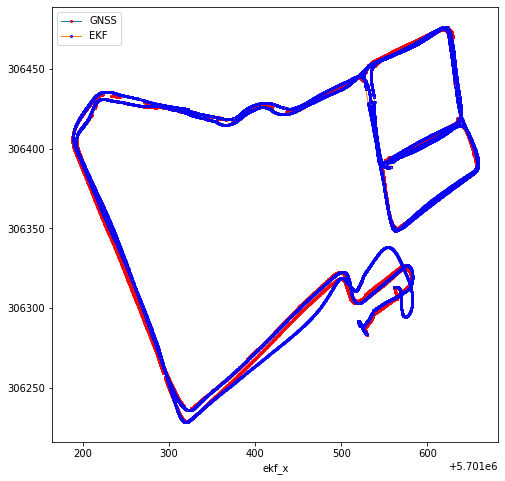

In [14]:
# TODO: visualize the result here

# %matplotlib notebook
# Missing parts are visualized in linearly interpolated blue lines

f, ax = plt.subplots(figsize=(8,8))

m.plot(x='z_x', y='z_y', label='GNSS', ax=ax, marker='o', markersize=2, linewidth=1, markeredgecolor='red')
m.plot(x='ekf_x', y='ekf_y', label='EKF', ax=ax, marker='o', markersize=2, linewidth=1, markeredgecolor='blue')
plt.legend()


### Tests

# TODO: write at least one test here


# The results are shown in the plots below with speed, heading and NEES of the filter

The filter is consists with the tracking module as per the Normalized Error Estimation Square (NEES) the filter is mostly consistant based on chi-squared in 95% range for 6 degree of freedom which 12.6

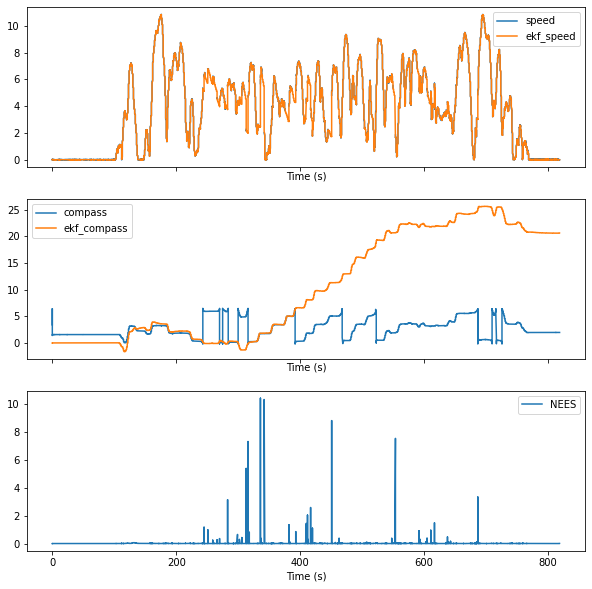

In [15]:
f, ax = plt.subplots(3, figsize=(10, 10), sharex=True)

#gnss_df['speed'] = np.sqrt(gnss_df.ve *gnss_df.ve + gnss_df.vn * gnss_df.vn + gnss_df.vu *gnss_df.vu )

plot_sensor(m, ax=ax[0], cols=['speed', 'ekf_speed'])

plot_sensor(m, ax=ax[1], cols=['compass', 'ekf_compass'])

plot_sensor(m, ax=ax[2], cols=['NEES'])


# Thank You for the time and problem